# Análise de Estrutura Secundária de Variantes DRD4
Este notebook realiza a análise comparativa das estruturas secundárias previstas para variantes da proteína DRD4.

**Pipeline:**
- Extrai estados secundários (H/E/C) e probabilidades (P(C), P(H), P(E)) de arquivos `.ss2` já alinhados.
- Usa a sequência NM_000797.4 como referência.
- Calcula métricas por posição: concordância estrita, consenso probabilístico, divergência (entropia, similaridade de cosseno), transições de estado.
- Agrega resultados em janelas deslizantes e segmentos contíguos.
- Resume por regiões funcionais e gera tabelas e gráficos informativos.

**Termos principais:**
- *Concordância estrita*: todas as variantes apresentam o mesmo estado secundário na posição.
- *Consenso probabilístico*: média das probabilidades dos estados secundários entre variantes.
- *Entropia*: grau de incerteza ou dispersão das probabilidades dos estados secundários.
- *Similaridade de cosseno*: mede o quão semelhantes são os perfis de probabilidade entre variantes.
- *Transições de estado*: número de mudanças de estado secundário entre variantes.

Essas análises permitem identificar regiões estáveis, divergentes e potenciais pontos críticos funcionais na proteína.

In [33]:
import os
import pandas as pd
import numpy as np

def read_ss2(path):
    rows = []
    with open(path) as f:
        for line in f:
            if line.startswith('#') or not line.strip():
                continue
            i, aa, ss, pc, ph, pe = line.split()[:6]
            rows.append({
                'pos': int(i),
                'aa': aa,
                'ss': ss,
                'P_C': float(pc),
                'P_H': float(ph),
                'P_E': float(pe)
            })
    return pd.DataFrame(rows)

folder = 'secondary_struct'
ss2_files = [f for f in os.listdir(folder) if f.endswith('.ss2')]

all_data = {}
for fname in ss2_files:
    name = fname.replace('.ss2', '')
    df = read_ss2(os.path.join(folder, fname))
    all_data[name] = df

print('Arquivos carregados:', list(all_data.keys()))

Arquivos carregados: ['HM191426.1', 'HM191427.1', 'HM191428.1', 'HM191429.1', 'HM191430.1', 'AY151032.1', 'AY151033.1', 'AY151034.1', 'AY151035.1', 'AY151036.1', 'HM191431.1', 'HM191432.1', 'HM191434.1', 'JQ064944.1', 'JQ064945.1', 'JQ064946.1', 'JQ064947.1', 'JQ064948.1', 'HM191421.1', 'HM191422.1', 'HM191423.1', 'HM191424.1', 'HM191425.1', 'AY151027.1', 'AY151031.1', 'AY151028.1', 'AY151029.1', 'AY151030.1', 'HM191418.1', 'HM191419.1', 'HM191420.1', 'JQ064942.1', 'JQ064943.1', 'JQ064952.1', 'JQ064953.1', 'NM_000797.4']


In [34]:
# Organizar matrizes de SS e probabilidades por posição (dados já alinhados)
ref_name = 'NM_000797.4'
df_ref = all_data[ref_name]
variant_names = list(all_data.keys())

ss_matrix = []  # estados secundários por variante
prob_matrix = []  # probabilidades por variante (lista de dicts: P_C, P_H, P_E)

for i in range(len(df_ref)):
    ss_row = []
    prob_row = []
    for name in variant_names:
        row = all_data[name].iloc[i]
        ss_row.append(row['ss'])
        prob_row.append({'P_C': row['P_C'], 'P_H': row['P_H'], 'P_E': row['P_E']})
    ss_matrix.append(ss_row)
    prob_matrix.append(prob_row)

# Exemplo: estados e probabilidades na posição 10
print('SS na posição 10:', ss_matrix[9])
print('Probabilidades na posição 10:', prob_matrix[9])

SS na posição 10: ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'H', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
Probabilidades na posição 10: [{'P_C': np.float64(0.75), 'P_H': np.float64(0.222), 'P_E': np.float64(0.018)}, {'P_C': np.float64(0.903), 'P_H': np.float64(0.12), 'P_E': np.float64(0.011)}, {'P_C': np.float64(0.711), 'P_H': np.float64(0.302), 'P_E': np.float64(0.011)}, {'P_C': np.float64(0.625), 'P_H': np.float64(0.394), 'P_E': np.float64(0.008)}, {'P_C': np.float64(0.791), 'P_H': np.float64(0.221), 'P_E': np.float64(0.011)}, {'P_C': np.float64(0.85), 'P_H': np.float64(0.159), 'P_E': np.float64(0.014)}, {'P_C': np.float64(0.905), 'P_H': np.float64(0.117), 'P_E': np.float64(0.011)}, {'P_C': np.float64(0.75), 'P_H': np.float64(0.222), 'P_E': np.float64(0.018)}, {'P_C': np.float64(0.831), 'P_H': np.float64(0.167), 'P_E': np.float64(0.012)}, {'P_C': np.float64(0.897), 'P_H': np.float64(0.123), '

## Organização dos dados alinhados
Esta célula organiza os dados extraídos dos arquivos `.ss2` já alinhados:
- Monta uma matriz de estados secundários (H/E/C) por posição para todas as variantes.
- Monta uma matriz de probabilidades (P_C, P_H, P_E) por posição para todas as variantes.
- Usa a sequência de referência `NM_000797.4` para garantir o alinhamento correto.
Essas matrizes serão usadas para calcular as métricas de concordância, consenso e divergência por posição.

## Cálculo das métricas por posição
Esta célula calcula as principais métricas para cada posição da proteína:
- **Concordância dura**: conta 1 se todas as variantes concordam no estado secundário (H/E/C), 0 se não.
- **Consenso suave**: média das probabilidades de cada estado secundário entre variantes.
- **Divergência**: entropia do consenso e média da similaridade de cosseno entre os vetores de probabilidade das variantes.
- **Transições de estado**: conta as mudanças de estado secundário entre variantes na posição.
Essas métricas permitem identificar regiões estáveis, divergentes e potenciais alterações funcionais.

In [35]:
from scipy.stats import entropy
from numpy.linalg import norm

def similaridade_cosseno(a, b):
    a, b = np.array(a), np.array(b)
    if norm(a) == 0 or norm(b) == 0:
        return np.nan
    return np.dot(a, b) / (norm(a) * norm(b))

metricas = []
for i, (ss_row, prob_row) in enumerate(zip(ss_matrix, prob_matrix)):
    # Concordância estrita (todas variantes concordam no estado secundário)
    concordancia_estrita = 1.0 if len(set(ss_row)) == 1 else 0.0
    # Consenso probabilístico: médias das probabilidades por estado
    media_probs = {k: np.mean([p[k] for p in prob_row]) for k in ['P_C', 'P_H', 'P_E']}
    # Entropia do consenso (incerteza/dispersão)
    entropia = entropy(list(media_probs.values()), base=2)
    # Média da similaridade de cosseno entre perfis de probabilidade das variantes
    cos_sims = []
    for idx1 in range(len(prob_row)):
        for idx2 in range(idx1+1, len(prob_row)):
            v1 = [prob_row[idx1]['P_C'], prob_row[idx1]['P_H'], prob_row[idx1]['P_E']]
            v2 = [prob_row[idx2]['P_C'], prob_row[idx2]['P_H'], prob_row[idx2]['P_E']]
            cos_sims.append(similaridade_cosseno(v1, v2))
    media_similaridade_cosseno = np.nanmean(cos_sims) if cos_sims else np.nan
    # Transições de estado entre variantes na posição (contagem de mudanças entre variantes)
    transicoes = sum([ss_row[j] != ss_row[j-1] for j in range(1, len(ss_row))])
    metricas.append({
        'pos': i+1,
        'aa_ref': df_ref.iloc[i]['aa'],
        'concordancia_estrita': concordancia_estrita,
        'media_P_C': media_probs['P_C'],
        'media_P_H': media_probs['P_H'],
        'media_P_E': media_probs['P_E'],
        'entropia': entropia,
        'media_similaridade_cosseno': media_similaridade_cosseno,
        'transicoes': transicoes
    })

df_metricas = pd.DataFrame(metricas)
df_metricas.head()

,pos,aa_ref,concordancia_estrita,media_P_C,media_P_H,media_P_E,entropia,media_similaridade_cosseno,transicoes
0,1,M,1.0,0.999000,0.000750,0.000000,0.008869,1.000000,0
1,2,G,1.0,0.956778,0.025167,0.006833,0.230322,0.999954,0
2,3,N,1.0,0.904861,0.076583,0.016667,0.511082,0.998845,0
3,4,R,1.0,0.750500,0.176056,0.051944,0.963618,0.981453,0
4,5,S,0.0,0.627278,0.281083,0.055833,1.159922,0.949515,4


## Agregação em janelas móveis
Esta célula calcula médias das métricas (ex.: concordância estrita, entropia) em janelas móveis ao longo da proteína.
Isso permite identificar regiões estáveis ou divergentes, suavizando o ruído posição a posição.

In [36]:
def janela_movel(df, tamanho_janela=9):
    resultado = []
    for i in range(len(df) - tamanho_janela + 1):
        win = df.iloc[i:i+tamanho_janela]
        resultado.append({
            'start': win['pos'].iloc[0],
            'end': win['pos'].iloc[-1],
            'media_concordancia_estrita': win['concordancia_estrita'].mean(),
            'media_entropia': win['entropia'].mean(),
            'media_similaridade_cosseno': win['media_similaridade_cosseno'].mean(),
            'media_transicoes': win['transicoes'].mean()
        })
    return pd.DataFrame(resultado)

df_janela = janela_movel(df_metricas, tamanho_janela=9)
df_janela.head()

,start,end,media_concordancia_estrita,media_entropia,media_similaridade_cosseno,media_transicoes
0,1,9,0.555556,0.789505,0.967764,3.111111
1,2,10,0.444444,0.888253,0.963855,3.333333
2,3,11,0.333333,0.969788,0.958322,3.555556
3,4,12,0.222222,1.032114,0.951510,4.333333
4,5,13,0.111111,1.046110,0.948123,5.111111


## Visualização dos resultados agregados
Esta célula gera gráficos para visualizar as métricas agregadas em janelas móveis ao longo da proteína.
- Linha de concordância estrita média por janela.
- Linha de entropia média por janela.
- Linha de transições médias por janela.
Essas visualizações ajudam a identificar regiões estáveis, divergentes e potenciais alterações funcionais.

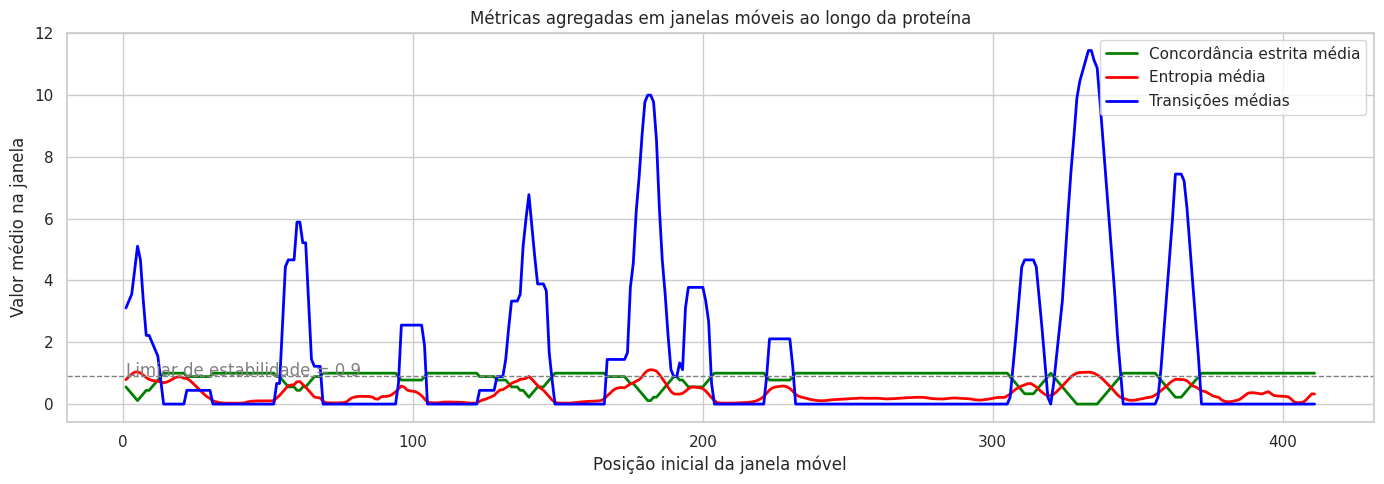

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo para artigo científico
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'axes.linewidth': 0.9,
    'lines.linewidth': 1.2,
    'figure.dpi': 150,
    'axes.grid': False
})

fig, ax = plt.subplots(figsize=(14,5))
sns.set_style('white')

# Plot das métricas
ax.plot(df_janela['start'], df_janela['media_concordancia_estrita'], label='Concordância estrita média', color='#2ca02c')
ax.plot(df_janela['start'], df_janela['media_entropia'], label='Entropia média', color='#d62728')
ax.plot(df_janela['start'], df_janela['media_transicoes'], label='Transições médias', color='#1f77b4')

# Rótulos e título
ax.set_xlabel('Posição inicial da janela móvel')
ax.set_ylabel('Valor médio na janela')
ax.set_title('Métricas agregadas em janelas móveis')

# Definir limites para garantir 0 nas margens (zero colado aos eixos)
ax.set_xlim(0, df_janela['start'].max() + 1)
ymax = max(df_janela[['media_concordancia_estrita','media_entropia','media_transicoes']].max()) * 1.05
ax.set_ylim(0, ymax)

# Limpar espinhas superiores/direitas e posicionar espinhas esquerda/inferior coladas ao 0
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))

# Ticks externos e legenda simples
ax.tick_params(axis='both', which='both', direction='out', length=4)
ax.legend(frameon=False, loc='upper right')

# Limiar de referência
ax.axhline(0.9, color='gray', linestyle='--', linewidth=0.8)
ax.text(0.5, 0.92, 'Limiar de estabilidade = 0.9', transform=ax.transAxes, ha='left', va='bottom', color='gray', fontsize=10)

plt.tight_layout()
plt.show()

## Detalhes da agregação em janelas móveis
Esta célula realiza a agregação das métricas calculadas por posição em janelas móveis ao longo da proteína. Para cada janela (exemplo: 9 resíduos), são calculadas as médias das principais métricas.

**Tabela gerada (`df_window`):**
- `start`: posição inicial da janela na sequência de referência.
- `end`: posição final da janela.
- `mean_hard_concord`: média da concordância estrita na janela (proporção de posições em que todas as variantes concordam no estado secundário).
- `mean_entropy`: média da entropia do consenso na janela (mede a incerteza/dispersão das probabilidades dos estados secundários; valores altos indicam maior divergência entre variantes).
- `mean_cos_sim`: média da similaridade de cosseno entre os vetores de probabilidade das variantes na janela (valores próximos de 1 indicam variantes semelhantes, próximos de 0 indicam divergência).
- `mean_transitions`: média do número de transições de estado secundário entre variantes por posição na janela (mais transições indicam maior discordância estrutural).

Essas médias suavizam o ruído posição a posição e ajudam a identificar regiões estáveis, divergentes ou potencialmente relevantes para função ou fenótipo.

## Detalhes da visualização das métricas agregadas
Esta célula gera gráficos de linha para as principais métricas agregadas em janelas móveis ao longo da proteína.

**Gráficos gerados:**
- **Concordância estrita média**: mostra, para cada janela, a proporção de posições em que todas as variantes concordam no estado secundário (H/E/C). Valores próximos de 1 indicam alta estabilidade estrutural; valores baixos indicam regiões divergentes.
- **Entropia média**: indica o grau de incerteza ou dispersão das probabilidades dos estados secundários entre variantes. Valores altos sugerem maior discordância ou variabilidade estrutural.
- **Transições médias**: mostra o número médio de mudanças de estado secundário entre variantes por posição na janela. Regiões com muitos H↔E/C indicam potencial relevância funcional ou instabilidade.

Esses gráficos permitem identificar rapidamente regiões estáveis, divergentes e potenciais pontos críticos funcionais ou estruturais na proteína.

**Gráfico 1: Métricas agregadas em janelas móveis**
Este gráfico mostra, ao longo da proteína, as médias das principais métricas calculadas em janelas móveis:
- **Concordância estrita média (verde):** Proporção de posições em que todas as variantes concordam no estado secundário. Valores altos indicam regiões estáveis.
- **Entropia média (vermelho):** Mede a incerteza/dispersão das probabilidades dos estados secundários. Valores altos indicam maior divergência entre variantes.
- **Transições médias (azul):** Número médio de mudanças de estado secundário entre variantes por posição. Regiões com muitos H↔E/C indicam potencial relevância funcional ou instabilidade.
A linha cinza tracejada indica o limiar de estabilidade (0,9).

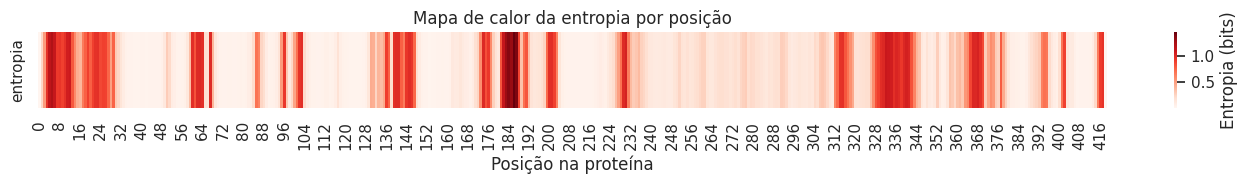

In [ ]:
fig, ax = plt.subplots(figsize=(14,2))
sns.set_style('white')
plt.rcParams.update({'font.size':10})

# Heatmap da entropia (transposta para ter posições no eixo x)
sns.heatmap(df_metricas[['entropia']].T, cmap='Reds', cbar_kws={'label': 'Entropia (bits)'}, ax=ax)

# Ajustes de eixos
ax.set_xlabel('Posição na proteína')
ax.set_yticks([])
ax.set_xlim(0, df_metricas.shape[0])
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))

plt.tight_layout()
plt.show()

**Gráfico 2: Mapa de calor da entropia por posição**
Este gráfico mostra a entropia (incerteza/divergência) das probabilidades dos estados secundários em cada posição da proteína.
- Regiões com tons mais escuros indicam maior entropia, ou seja, maior discordância entre variantes.
- Regiões claras indicam maior consenso e estabilidade estrutural.
Este mapa é útil para identificar rapidamente segmentos instáveis ou variáveis ao longo da sequência.

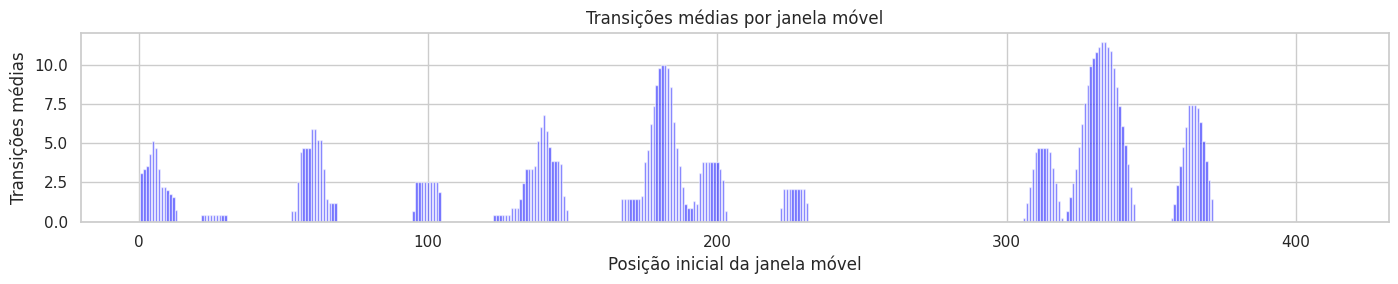

In [ ]:
fig, ax = plt.subplots(figsize=(14,3))
sns.set_style('white')

ax.bar(df_janela['start'], df_janela['media_transicoes'], color='#1f77b4', alpha=0.8)

ax.set_xlabel('Posição inicial da janela móvel')
ax.set_ylabel('Transições médias')
ax.set_title('Transições médias por janela móvel')

ax.set_xlim(0, df_janela['start'].max() + 1)
ax.set_ylim(0, df_janela['media_transicoes'].max() * 1.05)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))

ax.tick_params(axis='both', which='both', direction='out', length=4)

plt.tight_layout()
plt.show()

**Gráfico 3: Transições médias por janela móvel**
Este gráfico mostra, para cada janela móvel ao longo da proteína, o número médio de transições de estado secundário entre variantes.
- Barras mais altas indicam regiões com maior discordância estrutural entre variantes (mais mudanças de H↔E/C).
- Barras baixas indicam regiões mais estáveis e conservadas.
Este gráfico é útil para identificar hotspots de variabilidade estrutural e potenciais regiões de interesse funcional.